<a href="https://colab.research.google.com/github/rajkachhadiya123/Human-Mood-Recognition-/blob/main/HMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Collection and Pre-processing

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG19,VGG16,EfficientNetB0,EfficientNetB4 # Import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input # Import preprocess_input for ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Import ModelCheckpoint
import kagglehub
import os

#Training and Validation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
import os
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Paths (read-only Kaggle input)
import kagglehub

path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

drive.mount('/content/drive')
train_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/train')
val_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/test')

# === DATA AUGMENTATION & LOADERS ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
print("Class indices:", train_generator.class_indices)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3152 images belonging to 4 classes.
Found 788 images belonging to 4 classes.
Class indices: {'angry': 0, 'happy': 1, 'nothing': 2, 'sad': 3}


##VGG-16

In [ ]:
from google.colab import drive
from tensorflow.keras.models import load_model
drive.mount('/content/drive')
# !mkdir -p '/content/drive/MyDrive/models'

checkpoint_cb = ModelCheckpoint('HMR_VGG16_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

# === Build ResNet-50 Model ===
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Phase 1: Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# === Compile and Train Phase 1 ===
model.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training Phase 1: Frozen Base (VGG16)")
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=13,
    callbacks=[checkpoint_cb, earlystop_cb, reducelr_cb]
)

# === Phase 2: Fine-tuning ===
print("\nTraining Phase 2: Fine-tuning Top VGG Layers")

for layer in base_model.layers[-12:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7,
    callbacks=[checkpoint_cb, earlystop_cb, reducelr_cb]
)

VGG16_model = load_model('HMR_VGG16_model.keras', compile=False) # Load the best ResNet model
VGG16_model.save('/content/drive/MyDrive/models/HMR_VGG16_model.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Phase 1: Frozen Base (VGG16)
Epoch 1/13
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5351 - loss: 2.5764
Epoch 1: val_accuracy improved from -inf to 0.63198, saving model to HMR_VGG16_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 53s 486ms/step - accuracy: 0.5352 - loss: 2.5686 - val_accuracy: 0.6320 - val_loss: 0.7575 - learning_rate: 5.0000e-04
Epoch 2/13
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.6385 - loss: 0.9358
Epoch 2: val_accuracy did not improve from 0.63198
99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 380ms/step - accuracy: 0.6382 - loss: 0.9360 - val_accuracy: 0.5698 - val_loss: 0.8067 - learning_rate: 5.0000e-04
Epoch 3/13
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6237 - loss: 0.8060
Epoch 3: val_accuracy improved from 0.63198 to 0.63325, saving model to HMR_VGG16_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 282ms/step - acc

##VGG-19

In [ ]:
from google.colab import drive
from tensorflow.keras.models import load_model
drive.mount('/content/drive')
!mkdir -p '/content/drive/MyDrive/models'

checkpoint_cb = ModelCheckpoint('HMR_VGG19_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

# === Build VGG19 Model ===
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Phase 1: Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# === Compile and Train Phase 1 ===
model.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()
print("Training Phase 1: Frozen Base (VGG19)")
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=13,
    callbacks=[checkpoint_cb, earlystop_cb, reducelr_cb]
)

# === Phase 2: Fine-tuning ===
print("\nTraining Phase 2: Fine-tuning Top VGG19 Layers")

for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7,
    callbacks=[checkpoint_cb, earlystop_cb, reducelr_cb]
)

vgg_model = load_model('HMR_VGG19_model.keras', compile=False) # Load the best ResNet model
vgg_model.save('/content/drive/MyDrive/models/HMR_VGG19_model1.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Phase 1: Frozen Base (VGG19)
Epoch 1/13
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5100 - loss: 1.8187
Epoch 1: val_accuracy improved from -inf to 0.63579, saving model to HMR_VGG19_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 347ms/step - accuracy: 0.5106 - loss: 1.8137 - val_accuracy: 0.6358 - val_loss: 0.7781 - learning_rate: 5.0000e-04
Epoch 2/13
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.6421 - loss: 0.8223
Epoch 2: val_accuracy did not improve from 0.63579
99/99 ━━━━━━━━━━━━━━━━━━━━ 30s 299ms/step - accuracy: 0.6421 - loss: 0.8221 - val_accuracy: 0.6358 - val_loss: 0.7332 - learning_rate: 5.0000e-04
Epoch 3/13
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.6633 - loss: 0.7478
Epoch 3: val_accuracy improved from 0.63579 to 0.70939, saving model to HMR_VGG19_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 31s 315ms/step - acc

##ResNet-50

In [ ]:
from google.colab import drive
from tensorflow.keras.models import load_model
drive.mount('/content/drive')
# !mkdir -p '/content/drive/MyDrive/models'

checkpoint_cb = ModelCheckpoint('HMR_ResNet50_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

# === Build ResNet-50 Model ===
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Phase 1: Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# === Compile and Train Phase 1 ===
model.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training Phase 1: Frozen Base (ResNet50)")
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=13,
    callbacks=[checkpoint_cb, earlystop_cb, reducelr_cb]
)

# === Phase 2: Fine-tuning ===
print("\nTraining Phase 2: Fine-tuning Top ResNet Layers")

for layer in base_model.layers[-15:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7,
    callbacks=[checkpoint_cb, earlystop_cb, reducelr_cb]
)

resnet_model = load_model('HMR_ResNet50_model.keras', compile=False) # Load the best ResNet model
resnet_model.save('/content/drive/MyDrive/models/HMR_ResNet_50_model.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Phase 1: Frozen Base (ResNet50)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/13
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5674 - loss: 0.9857
Epoch 1: val_accuracy improved from -inf to 0.69797, saving model to HMR_ResNet50_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 67s 521ms/step - accuracy: 0.5680 - loss: 0.9843 - val_accuracy: 0.6980 - val_loss: 0.6555 - learning_rate: 5.0000e-04
Epoch 2/13
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7105 - loss: 0.6623
Epoch 2: val_accuracy improved from 0.69797 to 0.71574, saving model to HMR_ResNet50_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.7106 - loss: 0.6621 - val_accuracy: 0.7157 - val_loss: 0.6029 - learning_rate: 5.0000e-04
Epoch 3/13
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7543 - loss: 0.5704
Epoch 3: val_accuracy improved from 0.71574 to 0.72462, saving model to HMR_ResNet50_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.7542 - loss: 0.5705 - val_accuracy: 0.7246 - val_loss: 0.6059 - learning_rate: 5.0000e-04
Epoch 4/13
99/99 ━

##EfficientNet-B4

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
import os
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Paths (read-only Kaggle input)
import kagglehub

path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

drive.mount('/content/drive')
train_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/train')
val_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/test')

# === DATA AUGMENTATION & LOADERS ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
print("Class indices:", train_generator.class_indices)
from google.colab import drive
from tensorflow.keras.models import load_model
drive.mount('/content/drive')
# !mkdir -p '/content/drive/MyDrive/models'

checkpoint_cb = ModelCheckpoint('HMR_B4_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)

# === Build ResNet-50 Model ===
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(380, 380, 3))
base_model.trainable = False  # Phase 1: Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# === Compile and Train Phase 1 ===
model.compile(optimizer=Adam(learning_rate=5e-4), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training Phase 1: Frozen Base (B4)")
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=13,
    callbacks=[checkpoint_cb, earlystop_cb, reducelr_cb]
)

# === Phase 2: Fine-tuning ===
print("\nTraining Phase 2: Fine-tuning Top B4 Layers")

for layer in base_model.layers[-100:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7,
    callbacks=[checkpoint_cb, earlystop_cb, reducelr_cb]
)

resnet_model = load_model('HMR_B4_model.keras', compile=False) # Load the best ResNet model
resnet_model.save('/content/drive/MyDrive/models/HMR_B4_model.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3152 images belonging to 4 classes.
Found 788 images belonging to 4 classes.
Class indices: {'angry': 0, 'happy': 1, 'nothing': 2, 'sad': 3}
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Phase 1: Frozen Base (B4)
Epoch 1/13
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5021 - loss: 1.0945
Epoch 1: val_accuracy improved from -inf to 0.61675, saving model to HMR_B4_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5027 - loss: 1.0934 - val_accuracy: 0.6168 - val_loss: 0.8318 - learning_rate: 5.0000e-04
Epoch 2/13
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.5957 - loss: 0.8741
Epoch 2: val_accuracy improved from 0.61675 to 0.64213, saving model to HMR_B4_model.keras
99/99 ━━━━━━━━━━━━━━━━━━━━ 59s 597ms/step - accuracy: 0.5959 - lo

#Classification Report and Confusion Matrix

##VGG-16

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3152 images belonging to 4 classes.
Found 788 images belonging to 4 classes.
Class indices: {'angry': 0, 'happy': 1, 'nothing': 2, 'sad': 3}

VGG-19 model loaded successfully from /content/drive/MyDrive/models/HMR_VGG16_model.keras

Making predictions on the validation set using VGG-16...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step

Classification Report (VGG-16):
              precision    recall  f1-score   support

       angry       0.69      0.55      0.61       213
       happy       0.69      0.73      0.71       207
     nothing       0.99      1.00      1.00       219
         sad       0.49      0.58      0.54       149

    accuracy                           0.73       788
   macro avg       0.72      0.72      0.71       788
weighted avg       0.74      0.73      0.73       788


Confusion Matrix (VGG-16):


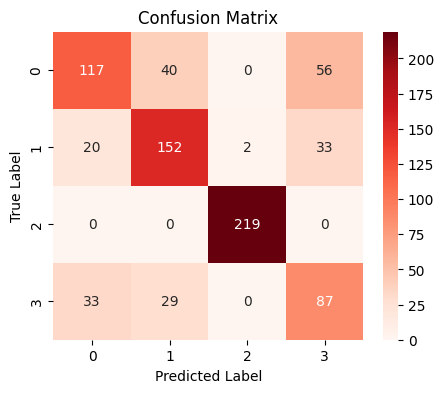

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
import os
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Paths (read-only Kaggle input)
import kagglehub

path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

drive.mount('/content/drive')
train_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/train')
val_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/test')

# === DATA AUGMENTATION & LOADERS ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
print("Class indices:", train_generator.class_indices)

# Define the path to the saved VGG-16 model file
model_path_vgg16 = '/content/drive/MyDrive/models/HMR_VGG16_model.keras'
vgg16_model = load_model(model_path_vgg16, compile=False)
print(f"\nVGG-19 model loaded successfully from {model_path_vgg16}")

    # Make predictions on the validation dataset
print("\nMaking predictions on the validation set using VGG-16...")
pred_probs_vgg16 = vgg16_model.predict(val_generator)

    # Convert the predicted class probabilities and the true class labels into class indices.
pred_indices_vgg16 = np.argmax(pred_probs_vgg16, axis=1)
true_indices_vgg16 = val_generator.classes

    # Retrieve the list of class labels
class_labels_vgg16 = list(val_generator.class_indices.keys())

    # Print the classification report
print("\nClassification Report (VGG-16):")
print(classification_report(true_indices_vgg16, pred_indices_vgg16, target_names=class_labels_vgg16))

    # Print the confusion matrix
print("\nConfusion Matrix (VGG-16):")
cf = confusion_matrix(true_indices_vgg16, pred_indices_vgg16)

plt.figure(figsize=(5, 4))
sns.heatmap(cf, annot=True, fmt='d', cmap='Reds') # Changed 'reds' to 'Reds'
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##VGG-19

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3152 images belonging to 4 classes.
Found 788 images belonging to 4 classes.
Class indices: {'angry': 0, 'happy': 1, 'nothing': 2, 'sad': 3}

VGG-19 model loaded successfully from /content/drive/MyDrive/models/HMR_VGG19_model1.keras

Making predictions on the validation set using VGG-19...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step

Classification Report (VGG-19):
              precision    recall  f1-score   support

       angry       0.79      0.57      0.66       213
       happy       0.70      0.76      0.73       207
     nothing       1.00      1.00      1.00       219
         sad       0.52      0.66      0.58       149

    accuracy                           0.76       788
   macro avg       0.75      0.75      0.74       788
weighted avg       0.77      0.76      0.76       788


Confusion Matrix (VGG-19):


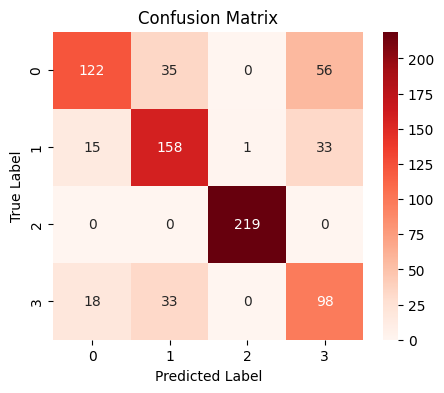

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
import os
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Paths (read-only Kaggle input)
import kagglehub

path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

drive.mount('/content/drive')
train_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/train')
val_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/test')

# === DATA AUGMENTATION & LOADERS ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
print("Class indices:", train_generator.class_indices)

# Define the path to the saved VGG-19 model file
model_path_vgg19 = '/content/drive/MyDrive/models/HMR_VGG19_model1.keras'
vgg19_model = load_model(model_path_vgg19, compile=False)
print(f"\nVGG-19 model loaded successfully from {model_path_vgg19}")

    # Make predictions on the validation dataset
print("\nMaking predictions on the validation set using VGG-19...")
pred_probs_vgg19 = vgg19_model.predict(val_generator)

    # Convert the predicted class probabilities and the true class labels into class indices.
pred_indices_vgg19 = np.argmax(pred_probs_vgg19, axis=1)
true_indices_vgg19 = val_generator.classes

    # Retrieve the list of class labels
class_labels_vgg19 = list(val_generator.class_indices.keys())

    # Print the classification report
print("\nClassification Report (VGG-19):")
print(classification_report(true_indices_vgg19, pred_indices_vgg19, target_names=class_labels_vgg19))

    # Print the confusion matrix
print("\nConfusion Matrix (VGG-19):")
cf = confusion_matrix(true_indices_vgg19, pred_indices_vgg19)

plt.figure(figsize=(5, 4))
sns.heatmap(cf, annot=True, fmt='d', cmap='Reds') # Changed 'reds' to 'Reds'
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##ResNet-50

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3152 images belonging to 4 classes.
Found 788 images belonging to 4 classes.
Class indices: {'angry': 0, 'happy': 1, 'nothing': 2, 'sad': 3}

ResNet-50 model loaded successfully from /content/drive/MyDrive/models/HMR_ResNet_50_model.keras

Making predictions on the validation set...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 552ms/step

Classification Report (ResNet-50):
              precision    recall  f1-score   support

       angry       0.68      0.53      0.60       213
       happy       0.77      0.69      0.73       207
     nothing       1.00      1.00      1.00       219
         sad       0.49      0.71      0.58       149

    accuracy                           0.74       788
   macro avg       0.73      0.73      0.73       788
weighted avg       0.76      0.74      0.74       788


Confusion Matrix (ResNet-50):


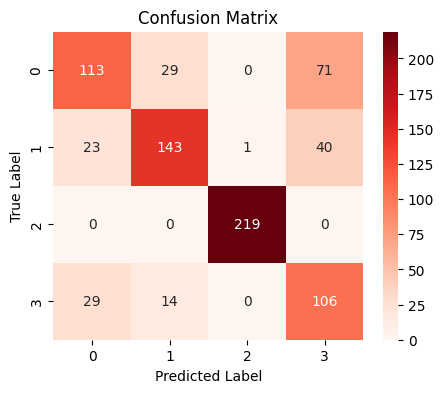

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
import os
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Paths (read-only Kaggle input)
import kagglehub

path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

drive.mount('/content/drive')
train_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/train')
val_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/test')

# === DATA AUGMENTATION & LOADERS ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
print("Class indices:", train_generator.class_indices)

model_path_ResNet = '/content/drive/MyDrive/models/HMR_ResNet_50_model.keras'
model = load_model(model_path_ResNet, compile=False)
print(f"\nResNet-50 model loaded successfully from {model_path_ResNet}")

print("\nMaking predictions on the validation set...")
pred_probs = model.predict(val_generator)
pred_indices = np.argmax(pred_probs, axis=1)
true_indices = val_generator.classes

class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report (ResNet-50):")
print(classification_report(true_indices, pred_indices, target_names=class_labels))

print("\nConfusion Matrix (ResNet-50):")
cnf = confusion_matrix(true_indices, pred_indices)

plt.figure(figsize=(5, 4))
sns.heatmap(cnf, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##EfficientNet-B4

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3152 images belonging to 4 classes.
Found 788 images belonging to 4 classes.
Class indices: {'angry': 0, 'happy': 1, 'nothing': 2, 'sad': 3}

B4 model loaded successfully from /content/drive/MyDrive/models/HMR_ResNet_50_model.keras

Making predictions on the validation set...
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step

Classification Report (B4):
              precision    recall  f1-score   support

       angry       0.61      0.49      0.54       213
       happy       0.70      0.63      0.66       207
     nothing       0.91      0.96      0.94       219
         sad       0.43      0.58      0.49       149

    accuracy                           0.67       788
   macro avg       0.66      0.66      0.66       788
weighted avg       0.68      0.67      0.67       788


Confusion Matrix (B4):


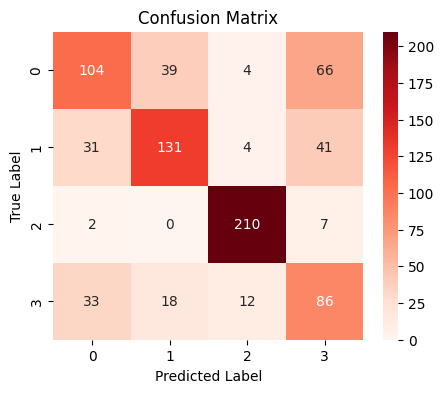

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
import os
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Paths (read-only Kaggle input)
import kagglehub

path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

drive.mount('/content/drive')
train_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/train')
val_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/test')

# === DATA AUGMENTATION & LOADERS ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
print("Class indices:", train_generator.class_indices)

model_path_B4 = '/content/drive/MyDrive/models/HMR_B4_model.keras'
model = load_model(model_path_B4, compile=False)
print(f"\nB4 model loaded successfully from {model_path_ResNet}")

print("\nMaking predictions on the validation set...")
pred_probs = model.predict(val_generator)
pred_indices = np.argmax(pred_probs, axis=1)
true_indices = val_generator.classes

class_labels = list(val_generator.class_indices.keys())

print("\nClassification Report (B4):")
print(classification_report(true_indices, pred_indices, target_names=class_labels))

print("\nConfusion Matrix (B4):")
cnf = confusion_matrix(true_indices, pred_indices)

plt.figure(figsize=(5, 4))
sns.heatmap(cnf, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#Real Image Testing

##VGG-16

✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step

🎯 Predicted Mood: sad



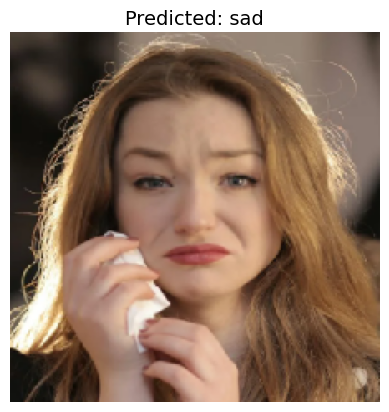

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
from tensorflow.keras.applications.vgg19 import preprocess_input # Import correct preprocess_input

# === CONFIG ===
MODEL_PATH = '/content/drive/MyDrive/models/HMR_VGG16_model.keras'             # ✅ Your model file
IMAGE_PATH = "sad2.png"             # ✅ Replace with your test image path
IMG_SIZE = (224, 224)
CLASS_LABELS = ['angry','happy','nothing','sad'] # ✅ Ensure correct order

# === LOAD MODEL ===
if not os.path.exists(MODEL_PATH):
    print(f"❌ Model not found at {MODEL_PATH}")
    sys.exit()

model = load_model(MODEL_PATH, compile=False)
print("✅ Model loaded successfully.")

# === LOAD & PREPROCESS IMAGE ===
if not os.path.exists(IMAGE_PATH):
    print(f"❌ Image not found at {IMAGE_PATH}")
    sys.exit()

# Load image in color
img = image.load_img(IMAGE_PATH, target_size=IMG_SIZE)


# Convert to array and reshape to (1, 224, 224, 3)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension

# Use the correct preprocess_input function for VGG19
img_array = preprocess_input(img_array)

# === PREDICT ===
pred = model.predict(img_array)[0] # Use img_array for prediction
predicted_index = np.argmax(pred)
predicted_label = CLASS_LABELS[predicted_index]
confidence = pred[predicted_index]

# === DISPLAY ===
print(f"\n🎯 Predicted Mood: {predicted_label}\n")

# Show image
plt.imshow(img) # Display color image
plt.title(f"Predicted: {predicted_label}", fontsize=14)
plt.axis('off')
plt.show()

# # Print all class scores
# print("📊 All Class Confidences:")
# for i, label in enumerate(CLASS_LABELS):
#     print(f"{label}: {pred[i]:.3f}")

##VGG-19

✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 630ms/step

🎯 Predicted Mood: happy



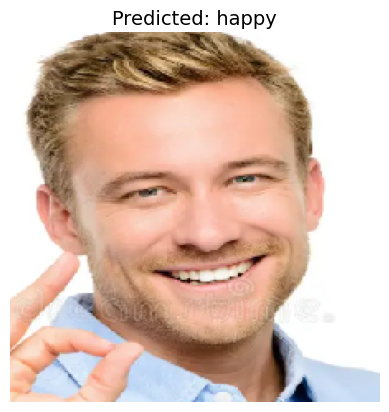

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
from tensorflow.keras.applications.vgg19 import preprocess_input # Import correct preprocess_input

# === CONFIG ===
MODEL_PATH = '/content/drive/MyDrive/models/HMR_VGG19_model1.keras'             # ✅ Your model file
IMAGE_PATH = "happy5.png"             # ✅ Replace with your test image path
IMG_SIZE = (224, 224)
CLASS_LABELS = ['angry','happy','nothing','sad'] # ✅ Ensure correct order

# === LOAD MODEL ===
if not os.path.exists(MODEL_PATH):
    print(f"❌ Model not found at {MODEL_PATH}")
    sys.exit()

model = load_model(MODEL_PATH, compile=False)
print("✅ Model loaded successfully.")

# === LOAD & PREPROCESS IMAGE ===
if not os.path.exists(IMAGE_PATH):
    print(f"❌ Image not found at {IMAGE_PATH}")
    sys.exit()

# Load image in color
img = image.load_img(IMAGE_PATH, target_size=IMG_SIZE)


# Convert to array and reshape to (1, 224, 224, 3)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension

# Use the correct preprocess_input function for VGG19
img_array = preprocess_input(img_array)

# === PREDICT ===
pred = model.predict(img_array)[0] # Use img_array for prediction
predicted_index = np.argmax(pred)
predicted_label = CLASS_LABELS[predicted_index]
confidence = pred[predicted_index]

# === DISPLAY ===
print(f"\n🎯 Predicted Mood: {predicted_label}\n")

# Show image
plt.imshow(img) # Display color image
plt.title(f"Predicted: {predicted_label}", fontsize=14)
plt.axis('off')
plt.show()

# # Print all class scores
# print("📊 All Class Confidences:")
# for i, label in enumerate(CLASS_LABELS):
#     print(f"{label}: {pred[i]:.3f}")

##ResNet-50

✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

🎯 Predicted Mood: angry



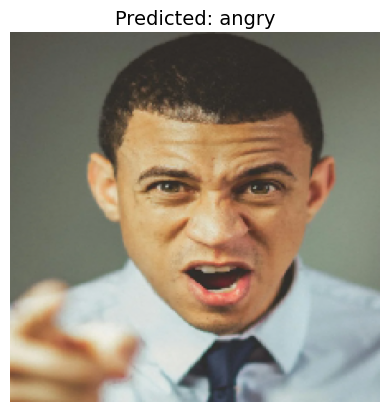

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
from tensorflow.keras.applications.vgg19 import preprocess_input # Import correct preprocess_input

# === CONFIG ===
MODEL_PATH = '/content/drive/MyDrive/models/HMR_ResNet_50_model.keras'             # ✅ Your model file
IMAGE_PATH = 'angry3.png'          # ✅ Replace with your test image path
IMG_SIZE = (224, 224)
CLASS_LABELS = ['angry','happy','nothing','sad'] # ✅ Ensure correct order

# === LOAD MODEL ===
if not os.path.exists(MODEL_PATH):
    print(f"❌ Model not found at {MODEL_PATH}")
    sys.exit()

model = load_model(MODEL_PATH, compile=False)
print("✅ Model loaded successfully.")

# === LOAD & PREPROCESS IMAGE ===
if not os.path.exists(IMAGE_PATH):
    print(f"❌ Image not found at {IMAGE_PATH}")
    sys.exit()

# Load image in color
img = image.load_img(IMAGE_PATH, target_size=IMG_SIZE)


# Convert to array and reshape to (1, 224, 224, 3)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension

# Use the correct preprocess_input function for VGG19
img_array = preprocess_input(img_array)

# === PREDICT ===
pred = model.predict(img_array)[0] # Use img_array for prediction
predicted_index = np.argmax(pred)
predicted_label = CLASS_LABELS[predicted_index]
confidence = pred[predicted_index]

# === DISPLAY ===
print(f"\n🎯 Predicted Mood: {predicted_label}\n")

# Show image
plt.imshow(img) # Display color image
plt.title(f"Predicted: {predicted_label}", fontsize=14)
plt.axis('off')
plt.show()

# # Print all class scores
# print("📊 All Class Confidences:")
# for i, label in enumerate(CLASS_LABELS):
#     print(f"{label}: {pred[i]:.3f}")

##EfficientNet-B4

✅ Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step

🎯 Predicted Mood: happy



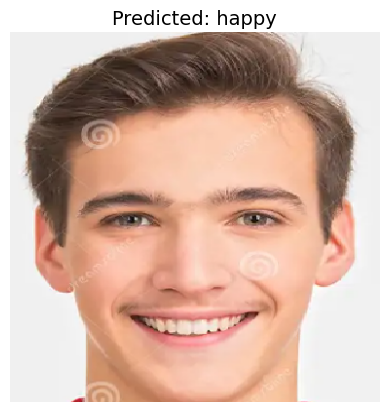

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
from tensorflow.keras.applications.vgg19 import preprocess_input # Import correct preprocess_input

# === CONFIG ===
MODEL_PATH = '/content/drive/MyDrive/models/HMR_B4_model.keras'             # ✅ Your model file
IMAGE_PATH = 'happy1.png'          # ✅ Replace with your test image path
IMG_SIZE = (380, 380)
CLASS_LABELS = ['angry','happy','nothing','sad'] # ✅ Ensure correct order

# === LOAD MODEL ===
if not os.path.exists(MODEL_PATH):
    print(f"❌ Model not found at {MODEL_PATH}")
    sys.exit()

model = load_model(MODEL_PATH, compile=False)
print("✅ Model loaded successfully.")

# === LOAD & PREPROCESS IMAGE ===
if not os.path.exists(IMAGE_PATH):
    print(f"❌ Image not found at {IMAGE_PATH}")
    sys.exit()

# Load image in color
img = image.load_img(IMAGE_PATH, target_size=IMG_SIZE)


# Convert to array and reshape to (1, 224, 224, 3)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension

# Use the correct preprocess_input function for VGG19
img_array = preprocess_input(img_array)

# === PREDICT ===
pred = model.predict(img_array)[0]
predicted_index = np.argmax(pred)
predicted_label = CLASS_LABELS[predicted_index]
confidence = pred[predicted_index]

# === DISPLAY ===
print(f"\n🎯 Predicted Mood: {predicted_label}\n")

# Show image
plt.imshow(img) # Display color image
plt.title(f"Predicted: {predicted_label}", fontsize=14)
plt.axis('off')
plt.show()


#Comparison

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
import os
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# Paths (read-only Kaggle input)
import kagglehub

path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

drive.mount('/content/drive')
train_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/train')
val_dir = os.path.join(path, 'EmotionsDataset_Splitted/data/test')

# === DATA AUGMENTATION & LOADERS ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(380, 380),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

model_path_b4 = '/content/drive/MyDrive/models/HMR_B4_model.keras'
b4_model = load_model(model_path_b4, compile=False)
b4_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


b4_loss, b4_acc = b4_model.evaluate(val_generator, verbose=1)

Mounted at /content/drive
Found 3152 images belonging to 4 classes.
Found 788 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5713 - loss: 0.8478


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 892ms/step - accuracy: 0.7517 - loss: 0.5994
VGG-16 Accuracy: 74.62%
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 488ms/step - accuracy: 0.7542 - loss: 0.5723
VGG-19 Accuracy: 74.49%
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 606ms/step - accuracy: 0.7548 - loss: 0.5631
ResNet-50 Accuracy: 73.60%
B4 Accuracy: 65.36%


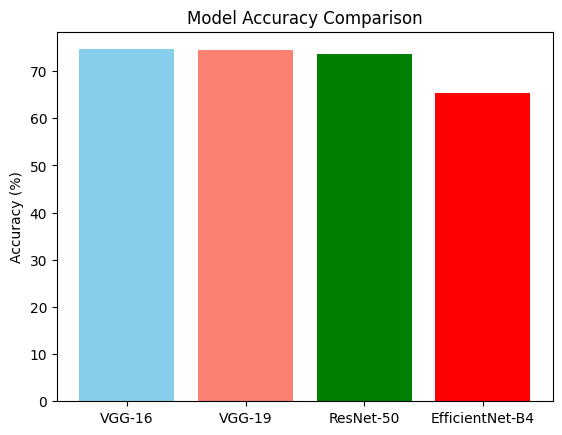

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from google.colab import drive
import os

drive.mount('/content/drive')
model_path_vgg19 = '/content/drive/MyDrive/models/HMR_VGG19_model1.keras'
vgg19_model = load_model(model_path_vgg19, compile=False)
vgg19_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy']) # Compile VGG19 model

model_path_ResNet = '/content/drive/MyDrive/models/HMR_ResNet_50_model.keras'
resnet_model = load_model(model_path_ResNet, compile=False)
resnet_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model_path_vgg = '/content/drive/MyDrive/models/HMR_VGG16_model.keras'
VGG16_model = load_model(model_path_vgg, compile=False)
VGG16_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model_path_b4 = '/content/drive/MyDrive/models/HMR_B4_model.keras'
b4_model = load_model(model_path_b4, compile=False)
b4_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_loss, vgg16_acc = VGG16_model.evaluate(val_generator, verbose=1)
print(f"VGG-16 Accuracy: {vgg16_acc * 100:.2f}%")

vgg_loss, vgg_acc = vgg19_model.evaluate(val_generator, verbose=1)
print(f"VGG-19 Accuracy: {vgg_acc * 100:.2f}%")

resnet_loss, resnet_acc = resnet_model.evaluate(val_generator, verbose=1)
print(f"ResNet-50 Accuracy: {resnet_acc * 100:.2f}%")

print(f"B4 Accuracy: {b4_acc * 100:.2f}%")

import matplotlib.pyplot as plt

models = ['VGG-16', 'VGG-19', 'ResNet-50', 'EfficientNet-B4']
accuracies = [vgg16_acc * 100,vgg_acc * 100, resnet_acc * 100, b4_acc*100]

plt.bar(models, accuracies, color=['skyblue', 'salmon', 'green', 'red'])
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.show()

VGG-16 Loss: 0.58
VGG-19 Loss: 0.59
ResNet-50 Loss: 0.59
B4 Loss: 0.73


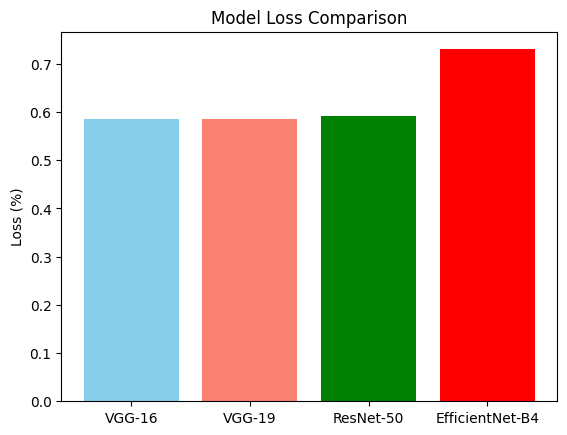

In [ ]:
import matplotlib.pyplot as plt

print(f"VGG-16 Loss: {vgg16_loss:.2f}")

print(f"VGG-19 Loss: {vgg_loss:.2f}")

print(f"ResNet-50 Loss: {resnet_loss:.2f}")

print(f"B4 Loss: {b4_loss:.2f}")

models = ['VGG-16', 'VGG-19', 'ResNet-50', 'EfficientNet-B4']
loss = [vgg16_loss ,vgg_loss , resnet_loss , b4_loss ]

plt.bar(models, loss, color=['skyblue', 'salmon', 'green', 'red'])
plt.ylabel("Loss (%)")
plt.title("Model Loss Comparison")
plt.show()